In [1]:
import networkx as nx
import pickle
import random
import scipy
from scipy.sparse import tril, find
import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt
import igraph
from django.core.management import call_command

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.tasks import *

from django.db.models import Count, Sum

qid= 6306
q = Query.objects.get(pk=qid)

sample = 0

# You need to call the management command to generate the network, if this is a new query
regenerate_matrix = False
if regenerate_matrix:
    call_command('citation_matrix', qid)
    call_command('bib_matrix', qid, 0, "/home/galm/projects/energy-demand/citation_data")

Cmat = scipy.sparse.load_npz(f'citation_data/bibCouple_q_{qid}_{sample}.npz')

with open(f"citation_data/docnet_dict_q_{qid}_{sample}.pickle", "rb") as f:
    m_dict = pickle.load(f)
with open(f"citation_data/docnet_revdict_q_{qid}_{sample}.pickle", "rb") as f:
    rev_m_dict = pickle.load(f)

Cmat.data *= Cmat.data>=1
Cmat.eliminate_zeros()

Cmat



3000
0
1000
2000
3000
1360532
ROWIDS
colids
data
matrix
transpose
multiply


<25430x25430 sparse matrix of type '<class 'numpy.int64'>'
	with 6067794 stored elements in Compressed Sparse Row format>

In [2]:


def check_cites(bc,rev_m_dict, i=0):
    d1 = Doc.objects.get(pk=rev_m_dict[bc[0][i]])
    d2 = Doc.objects.get(pk=rev_m_dict[bc[1][i]])
    print(bc[2][i])
    return set(d2.wosarticle.cr) & set(d1.wosarticle.cr)

bc = find(tril(Cmat,k=-1))

check_cites(bc, rev_m_dict, 1)



1


{'Greening LA, 2000, ENERG POLICY, V28, P389'}

In [3]:


## TODO read graph better, use find, get edge weights and 
def read_network(Cmat, rev_m_dict, doc_ids=None):
    g = igraph.Graph()
    g.add_vertices(len(rev_m_dict))
    edges = []
    weights = []
    n1s, n2s, ews = find(tril(Cmat,k=-1))
    for i, n1 in enumerate(n1s):
        if doc_ids:
            if rev_m_dict[n1] not in doc_ids or rev_m_dict[n2s[i]] not in doc_ids:
                continue
        e = (n1,n2s[i])
        edges.append(e)
        weights.append(ews[i])
    g.add_edges(edges)
    g.es["weight"] = weights

    g.vs["doc_id"] = list(rev_m_dict.values())
    return g
    pass

g = read_network(Cmat, rev_m_dict)
g = g.clusters().giant()
print(g.summary())







IGRAPH U-W- 24187 3021043 -- 
+ attr: doc_id (v), weight (e)


In [4]:
from fa2 import ForceAtlas2

forceatlas2 = ForceAtlas2(
    # Behavior alternatives
    outboundAttractionDistribution=True,  # Dissuade hubs
    linLogMode=False,  # NOT IMPLEMENTED
    adjustSizes=False,  # Prevent overlap (NOT IMPLEMENTED)
    edgeWeightInfluence=1,

    # Performance
    jitterTolerance=1.0,  # Tolerance
    barnesHutOptimize=True,
    barnesHutTheta=1.2,
    multiThreaded=False,  # NOT IMPLEMENTED

    # Tuning
    scalingRatio=2.0,
    strongGravityMode=False,
    gravity=0.6,

    # Log
    verbose=True
)

positions = forceatlas2.forceatlas2_igraph_layout(
    g, pos=None, iterations=1000, weight_attr="weight"
)

100%|██████████| 1000/1000 [20:12<00:00,  1.21s/it]


BarnesHut Approximation  took  361.07  seconds
Repulsion forces  took  711.17  seconds
Gravitational forces  took  1.23  seconds
Attraction forces  took  117.32  seconds
AdjustSpeedAndApplyForces step  took  8.42  seconds


In [5]:
def draw_network(ax, g, layout, labels, interactive=False, clusters=None, rev_m_dict=None, pos="top"):
    #label_ids = [l['id'] for l in labels]
    ax.grid(False)
    ax.axis('off')
    
    x_offset=0
    if clusters:
        if rev_m_dict:
            pass
            
        for c in clusters:
            x = [x[0] for i,x in enumerate(layout) if i in c]
            y = [x[1] for i,x in enumerate(layout) if i in c] 
            scatter = ax.scatter(x,y,edgecolor="black")
            
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xrange = xlim[1] - xlim[0]
        yrange = ylim[1] - ylim[0]
        x_step = xrange/3
        if pos=="top":
            ha = "center"
            x_offset = x_step/2
        else:
            ha="left"
            x_offset = xrange
        y_offset = 0
        texts = []
        for i,c in enumerate(clusters):
            x = [x[0] for i,x in enumerate(layout) if i in c]
            y = [x[1] for i,x in enumerate(layout) if i in c] 
            scatter = ax.scatter(x,y,edgecolor="black")
            col = scatter.get_facecolors()[0]
            cx, cy = sum(x) / len(x), sum(y) / len(y)
            ids = [rev_m_dict[x] for x in c]
            #docs = Doc.objects.filter(query=qid,pk__in=ids)
            dos = DocOwnership.objects.filter(
                doc__id__in=ids,
                query__project=q.project,
                relevant=1
            ).values('query__category__name').annotate(
                n = Count('pk')
            ).order_by('-n')
            df = pd.DataFrame.from_dict(list(dos))
            #df = pd.DataFrame.from_dict(list(docs.values('doccat__category__name').annotate(
            #    n=Count('pk')
            #).order_by('-n')))
            df['pc'] = round(df['n'] / df['n'].sum(),2)
            t = f"Cluster {i} - {len(ids)} docs\n\n{get_text(df)}"
            text = ax.text(
                    xlim[0]+x_offset,
                    ylim[1]+y_offset,
                    t,
                    bbox={'facecolor':col, 'alpha':0.5, 'pad':0.4, 'boxstyle': 'round'},
                    va="top",
                    ha=ha
                )
            texts.append(text)
            if pos=="top":
                x_offset+=x_step
                if xlim[0]+x_offset > xlim[1]:
                    fig.canvas.draw()
                    bs = []
                    for t in texts:
                        box = t.get_bbox_patch().get_window_extent()
                        tcbox = ax.transData.inverted().transform(box)
                        bs.append(tcbox[0][1])

                    y_offset+=min(bs)-ylim[1]
                    x_offset = x_step/2
            else:
                fig.canvas.draw()
                box = text.get_bbox_patch().get_window_extent()
                tcbox = ax.transData.inverted().transform(box)
                b = tcbox[0][1]

                y_offset=b-ylim[1] -50             
            
            
            #ax.text(cx, cy, "ASDFASDFASFD")
    else:
        x = [x[0] for x in layout]
        y = [x[1] for x in layout]
        scatter = ax.scatter(x,y,edgecolor="black")

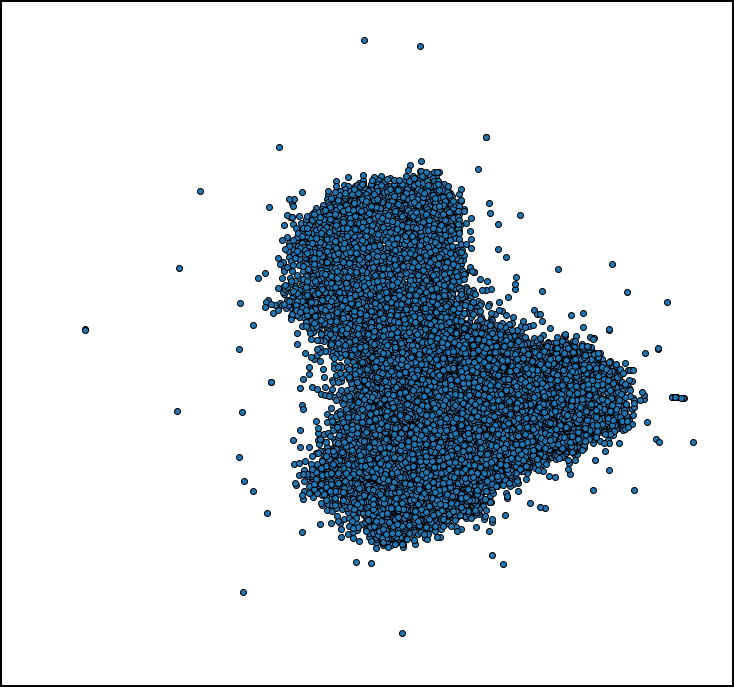

In [6]:
fig, ax = plt.subplots(figsize=(12,12),edgecolor="black",frameon=True,linewidth=4)

draw_network(ax, g, positions, [])

plt.show()

In [7]:
clusters = g.community_fastgreedy(weights="weight")
cl = clusters.as_clustering()

In [29]:
def summarise_cluster(cl, rev_m_dict, qs, c_threshold):
    ids = [rev_m_dict[x] for x in cl]
    docs = Doc.objects.filter(
        pk__in=ids,
        query__in=qs
    ).values('query__title').annotate(
        n=Count('pk')
    )
    df = pd.DataFrame.from_dict(list(docs))
    df['pc'] = round(df['n'] / df['n'].sum(),2)
    t = "\n".join([f"{r['query__title']} - {r['pc']:.0%}" for i,r in df.iterrows() if r['pc']>c_threshold])
    return t




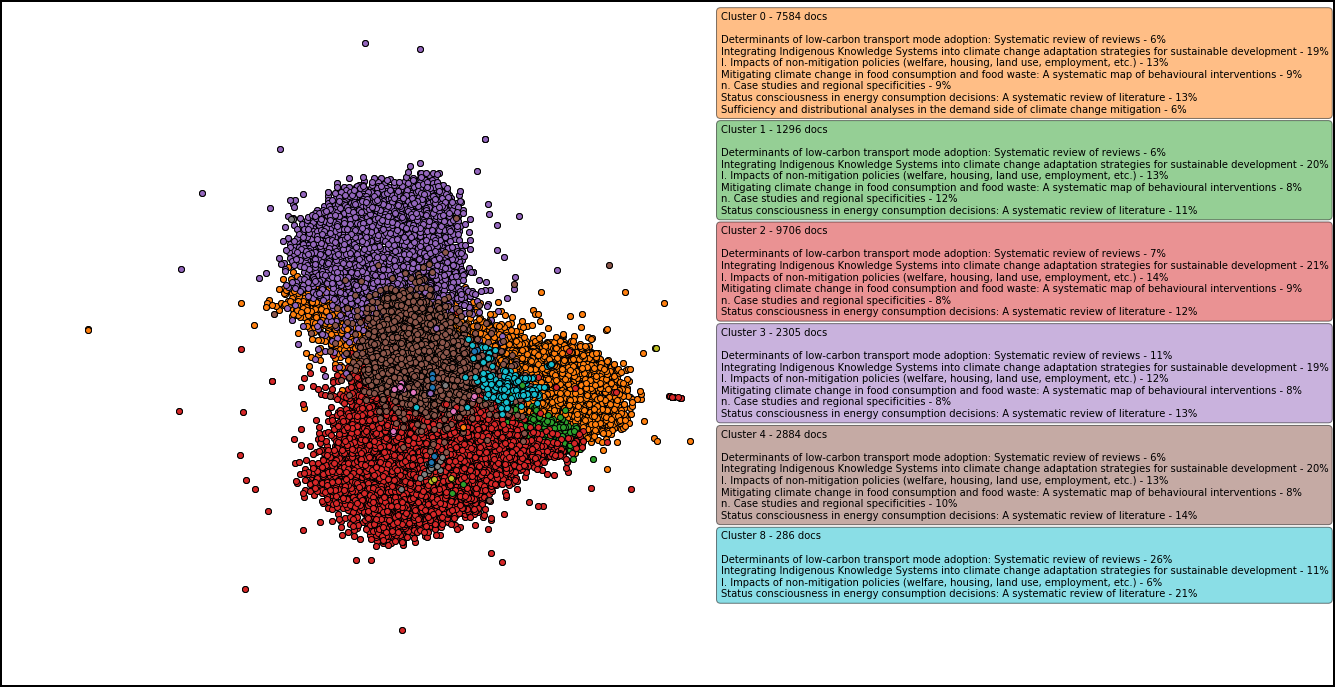

In [34]:
def draw_network(ax, g, layout, labels, 
                 interactive=False, clusters=None, 
                 qs=None, min_c_size=0,
                 c_threshold=0.1,
                 rev_m_dict=None, pos="top"):
    #label_ids = [l['id'] for l in labels]
    ax.grid(False)
    ax.axis('off')
    
    x_offset=0
    if clusters:
        if rev_m_dict:
            pass
            
        for c in clusters:
            x = [x[0] for i,x in enumerate(layout) if i in c]
            y = [x[1] for i,x in enumerate(layout) if i in c] 
            scatter = ax.scatter(x,y,edgecolor="black")
            
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        xrange = xlim[1] - xlim[0]
        yrange = ylim[1] - ylim[0]
        x_step = xrange/3
        if pos=="top":
            ha = "center"
            x_offset = x_step/2
        else:
            ha="left"
            x_offset = xrange
        y_offset = 0
        texts = []
        for i,c in enumerate(clusters):
            x = [x[0] for i,x in enumerate(layout) if i in c]
            y = [x[1] for i,x in enumerate(layout) if i in c] 
            scatter = ax.scatter(x,y,edgecolor="black")
            if len(c) < min_c_size:
                continue
            col = scatter.get_facecolors()[0]
            t = f"Cluster {i} - {len(c)} docs\n\n{summarise_cluster(c,rev_m_dict,qs,c_threshold)}"
            text = ax.text(
                    xlim[0]+x_offset,
                    ylim[1]+y_offset,
                    t,
                    bbox={'facecolor':col, 'alpha':0.5, 'pad':0.4, 'boxstyle': 'round'},
                    va="top",
                    ha=ha
                )
            texts.append(text)
            if pos=="top":
                x_offset+=x_step
                if xlim[0]+x_offset > xlim[1]:
                    fig.canvas.draw()
                    bs = []
                    for t in texts:
                        box = t.get_bbox_patch().get_window_extent()
                        tcbox = ax.transData.inverted().transform(box)
                        bs.append(tcbox[0][1])

                    y_offset+=min(bs)-ylim[1]
                    x_offset = x_step/2
            else:
                fig.canvas.draw()
                box = text.get_bbox_patch().get_window_extent()
                tcbox = ax.transData.inverted().transform(box)
                b = tcbox[0][1]

                y_offset=b-ylim[1] -450             
            
            
            #ax.text(cx, cy, "ASDFASDFASFD")
    else:
        x = [x[0] for x in layout]
        y = [x[1] for x in layout]
        scatter = ax.scatter(x,y,edgecolor="black")

# Here we select the queries we are interested in,
# I'm getting rid of literature survey, because it dominates the results
qs = Query.objects.filter(
    project=147,
).exclude(
    pk__in=[6262,6265,6256,6263,6260,6303,6299,6270, 6254] 
).order_by('r_count')
                   
p2 = Project.objects.get(pk=148)
qs2 = p2.query_set.filter(
    database="WoS",title__iregex="^[a-z]\."
).order_by('title')
all_qs = list(qs)+list(qs2)

fig, ax = plt.subplots(figsize=(12,12),edgecolor="black",frameon=True,linewidth=4)

draw_network(
    ax, g, positions, [], clusters=cl, 
    rev_m_dict=rev_m_dict, qs=all_qs,
    min_c_size=50, # Only label clusters with more than this number of documents
    pos="right",
    c_threshold=0.05
)

plt.savefig(f"plots/citation_networks/bibgraph_couple_forceatlas_fastgreedy_{qid}.svg")
plt.savefig(
    f"plots/citation_networks/bibgraph_couple_forceatlas_fastgreedy_{qid}.png",
    bbox_inches="tight"
)

plt.show()